In [39]:
import IPython
import numpy as np
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T
from matplotlib import pyplot as plt 
import math 

2.5. Exercises for TensorIR¶

2.4.5.1: Exercise using j_factor

In [14]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"],
                B: T.Buffer[(128, 128), "float32"],
                C: T.Buffer[(128, 128), "float32"]):
        T.func_attr({"global_symbol": "mm_relu", "tir.noalias": True})
        Y = T.alloc_buffer((128, 128), dtype="float32")
        for i, j, k in T.grid(128, 128, 128):
            with T.block("Y"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j)
                vk = T.axis.reduce(128, k)
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j)
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [30]:
def transform(mod, jfactor):
    sch = tvm.tir.Schedule(mod)
    block_Y = sch.get_block("Y", func_name="mm_relu")
    i, j, k = sch.get_loops(block_Y)
    j0, j1 = sch.split(j, factors=[None, jfactor])
    sch.reorder(j0, k, j1)
    block_C = sch.get_block("C", "mm_relu")
    sch.reverse_compute_at(block_C, j0)
    return sch.mod

def try_with_jfactor(jfactor: int):
    dtype = "float32"
    a_np = np.random.rand(128, 128).astype(dtype)
    b_np = np.random.rand(128, 128).astype(dtype)
    a_nd = tvm.nd.array(a_np)
    b_nd = tvm.nd.array(b_np)
    c_nd = tvm.nd.empty((128, 128), dtype="float32")
    type(c_nd)

    mod_transformed = transform(MyModule, jfactor=jfactor)

    rt_lib_transformed = tvm.build(mod_transformed, "llvm")
    f_timer_transformed = rt_lib_transformed.time_evaluator("mm_relu", tvm.cpu())
    return f_timer_transformed(a_nd, b_nd, c_nd).mean, mod_transformed

jfactor 1: 0.0041351483299999995 (s)
jfactor 2: 0.00079739957 (s)
jfactor 3: 0.00069842332 (s)
jfactor 4: 0.00043632374 (s)
jfactor 5: 0.00046278751000000006 (s)
jfactor 6: 0.00038469499999999995 (s)
jfactor 7: 0.0004572849899999999 (s)
jfactor 8: 0.00026756834 (s)
jfactor 9: 0.00045595999999999994 (s)
jfactor 10: 0.00024293291 (s)
jfactor 11: 0.00029557875 (s)
jfactor 12: 0.00023001959000000004 (s)
jfactor 13: 0.00021380124999999996 (s)
jfactor 14: 0.00026665916 (s)
jfactor 15: 0.00029555294 (s)
jfactor 16: 0.00038959001 (s)
jfactor 17: 0.00029445958 (s)
jfactor 18: 0.00026651707 (s)
jfactor 19: 0.00021114209 (s)
jfactor 20: 0.00016973415999999998 (s)
jfactor 21: 0.00046122000000000003 (s)
jfactor 22: 0.00013955376999999998 (s)
jfactor 23: 0.00047349082000000005 (s)
jfactor 24: 0.00035822041999999997 (s)
jfactor 25: 0.00085088127 (s)
jfactor 26: 0.00107116625 (s)
jfactor 27: 0.00076521833 (s)
jfactor 28: 0.00125315668 (s)
jfactor 29: 0.0011655641700000002 (s)
jfactor 30: 0.00140075377

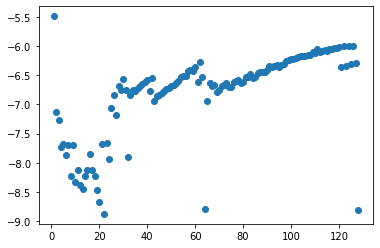

In [44]:
mean_benchmarks = []
jfactors = []

for jfactor in range(1, 129):
    times = []
    for repeats in range(10):
        time, mod_transformed = try_with_jfactor(jfactor)
        times.append(time)
    mean_benchmark = sum(times) / len(times)
    print(f"jfactor {jfactor}: {mean_benchmark} (s)")
    mean_benchmarks.append(mean_benchmark)
    jfactors.append(jfactor)

log_mean_benchmarks = [math.log(d) for d in mean_benchmarks]
plt.scatter(jfactors, log_mean_benchmarks)

log_mean_benchmarks = [(log_mean_benchmarks[i], i + 1) for i in range(len(log_mean_benchmarks))]
log_mean_benchmarks = sorted(log_mean_benchmarks)
print(log_mean_benchmarks)

# 22 jfactor, 128, and 64 are the fastest! Weird that 22 is so fast...
# Also shape of graph is weird... perhaps related to some kind of codegen thing?

2.5.1.1. Example: Element-wise Add

In [3]:
# init data
a = np.arange(16).reshape(4, 4)
b = np.arange(16, 0, -1).reshape(4, 4)

In [4]:
# numpy version
c_np = a + b
c_np

array([[16, 16, 16, 16],
       [16, 16, 16, 16],
       [16, 16, 16, 16],
       [16, 16, 16, 16]])

In [5]:
# low-level numpy version
def lnumpy_add(a: np.ndarray, b: np.ndarray, c: np.ndarray):
  for i in range(4):
    for j in range(4):
      c[i, j] = a[i, j] + b[i, j]
c_lnumpy = np.empty((4, 4), dtype=np.int64)
lnumpy_add(a, b, c_lnumpy)
c_lnumpy

array([[16, 16, 16, 16],
       [16, 16, 16, 16],
       [16, 16, 16, 16],
       [16, 16, 16, 16]])

In [6]:
# TensorIR version
@tvm.script.ir_module
class MyAdd:
  @T.prim_func
  def add(A: T.Buffer[(4, 4), "int64"],
          B: T.Buffer[(4, 4), "int64"],
          C: T.Buffer[(4, 4), "int64"]):
    T.func_attr({"global_symbol": "add"})
    for i, j in T.grid(4, 4):
      with T.block("C"):
        vi = T.axis.spatial(4, i)
        vj = T.axis.spatial(4, j)
        C[vi, vj] = A[vi, vj] + B[vi, vj]

rt_lib = tvm.build(MyAdd, target="llvm")
a_tvm = tvm.nd.array(a)
b_tvm = tvm.nd.array(b)
c_tvm = tvm.nd.array(np.empty((4, 4), dtype=np.int64))
rt_lib["add"](a_tvm, b_tvm, c_tvm)
np.testing.assert_allclose(c_tvm.numpy(), c_np, rtol=1e-5)

2.5.1.2. Exercise 1: Broadcast Add

In [7]:
# init data
a = np.arange(16).reshape(4, 4)
b = np.arange(4, 0, -1).reshape(4)

In [8]:
# numpy version
c_np = a + b
c_np

array([[ 4,  4,  4,  4],
       [ 8,  8,  8,  8],
       [12, 12, 12, 12],
       [16, 16, 16, 16]])

In [9]:
@tvm.script.ir_module
class MyAdd:
  @T.prim_func
  def add(
      A: T.Buffer[(4, 4), "int64"], 
      B: T.Buffer[(4), "int64"],
      C: T.Buffer[(4, 4), "int64"]
    ):
        T.func_attr({"global_symbol": "add", "tir.noalias": True})
        for i, j in T.grid(4, 4):
            with T.block("C"):
                vi = T.axis.spatial(4, i)
                vj = T.axis.spatial(4, j)
                C[vi, vj] = A[vi, vj] + B[vj]

rt_lib = tvm.build(MyAdd, target="llvm")
a_tvm = tvm.nd.array(a)
b_tvm = tvm.nd.array(b)
c_tvm = tvm.nd.array(np.empty((4, 4), dtype=np.int64))
rt_lib["add"](a_tvm, b_tvm, c_tvm)
np.testing.assert_allclose(c_tvm.numpy(), c_np, rtol=1e-5)

2.5.1.3. Exercise 2: 2D Convolution¶


In [10]:
N, CI, H, W, CO, K = 1, 1, 8, 8, 2, 3
OUT_H, OUT_W = H - K + 1, W - K + 1
data = np.arange(N*CI*H*W).reshape(N, CI, H, W)
weight = np.arange(CO*CI*K*K).reshape(CO, CI, K, K)

In [11]:
# torch version
import torch

data_torch = torch.Tensor(data)
weight_torch = torch.Tensor(weight)
conv_torch = torch.nn.functional.conv2d(data_torch, weight_torch)
conv_torch = conv_torch.numpy().astype(np.int64)
conv_torch

array([[[[                474,                 510,
                          546,                 582,
                          618,                 654],
         [                762,                 798,
                          834,                 870,
                          906,                 942],
         [               1050,                1086,
                         1122,                1158,
                         1194,                1230],
         [               1338,                1374,
                         1410,                1446,
                         1482,                1518],
         [               1626,                1662,
                         1698,                1734,
                         1770,                1806],
         [               1914,                1950,
                         1986,                2022,
                         2058,                2094]],

        [[                  0, 9223372036854775807,
    

In [12]:
@tvm.script.ir_module
class MyConv:
  N, CI, H, W, CO, K = 1, 1, 8, 8, 2, 3
  OUT_H, OUT_W = H - K + 1, W - K + 1
  @T.prim_func
  def conv(
    in_img: T.Buffer[(1, 1, 8, 8), "int64"],
    filters: T.Buffer[(2, 1, 3, 3), "int64"],
    out_img: T.Buffer[(1, 2, 6, 6), "int64"]
  ):
    T.func_attr({"global_symbol": "conv", "tir.noalias": True})
    for n, co, i, j, kh, kw in T.grid(1, 2, 6, 6, 3, 3):
      with T.block("conv"):
        vn, vco, vi, vj, vkh, vkw = T.axis.remap("SSSSRR", [n, co, i, j, kh, kw]) 
        with T.init():
          out_img[vn, vco, vi, vj] = T.int64(0)
        out_img[vn, vco, vi, vj] += in_img[0, 0, vi + vkh, vj + vkw] * filters[vco, 0, vkh, vkw]

In [13]:
rt_lib = tvm.build(MyConv, target="llvm")
data_tvm = tvm.nd.array(data)
weight_tvm = tvm.nd.array(weight)
conv_tvm = tvm.nd.array(np.empty((N, CO, OUT_H, OUT_W), dtype=np.int64))
rt_lib["conv"](data_tvm, weight_tvm, conv_tvm)
np.testing.assert_allclose(conv_tvm.numpy(), conv_torch, rtol=1e-5)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 36 / 72 (50%)
Max absolute difference: 9223372036854774487
Max relative difference: 1.
 x: array([[[[ 474,  510,  546,  582,  618,  654],
         [ 762,  798,  834,  870,  906,  942],
         [1050, 1086, 1122, 1158, 1194, 1230],...
 y: array([[[[                474,                 510,
                          546,                 582,
                          618,                 654],...

2.5.2.2 Batch Matmul

In [ ]:
def lnumpy_mm_relu_v2(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    Y = np.empty((16, 128, 128), dtype="float32")
    for n in range(16):
        for i in range(128):
            for j in range(128):
                for k in range(128):
                    if k == 0:
                        Y[n, i, j] = 0
                    Y[n, i, j] = Y[n, i, j] + A[n, i, k] * B[n, k, j]
    for n in range(16):
        for i in range(128):
            for j in range(128):
                C[n, i, j] = max(Y[n, i, j], 0)

In [ ]:
@tvm.script.ir_module
class MyBmmRelu:
  @T.prim_func
  def bmm_relu(
      A: T.Buffer[(16, 128, 128), "float32"],
      B: T.Buffer[(16, 128, 128), "float32"],
      C: T.Buffer[(16, 128, 128), "float32"]
  ):
    T.func_attr({"global_symbol": "bmm_relu", "tir.noalias": True})

    intermediate = T.alloc_buffer((16, 128, 128), "float32")
    for n, i, j, k in T.grid(16, 128, 128, 128):
      with T.block("matmul"):
        vn, vi, vj, vk = T.axis.remap("SSSR", [n, i, j, k])
        with T.init(): 
          intermediate[vn, vi, vj] = T.float32(0)
        intermediate[vn, vi, vj] += A[vn, vi, vk] * B[vn, vk, vj]
    for n, i, j in T.grid(16, 128, 128):
      with T.block("relu"):
        vn, vi, vj = T.axis.remap("SSS", [n, i, j])
        C[vn, vi, vj] = T.max(intermediate[vn, vi, vj], T.float32(0))

print(MyBmmRelu.script())
#sch = tvm.tir.Schedule(MyBmmRelu)
#IPython.display.Code(sch.mod.script(), language="python")
# Also please validate your result

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def bmm_relu(A: T.Buffer[(16, 128, 128), "float32"], B: T.Buffer[(16, 128, 128), "float32"], C: T.Buffer[(16, 128, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "bmm_relu", "tir.noalias": True})
        # body
        # with T.block("root")
        intermediate = T.alloc_buffer([16, 128, 128], dtype="float32")
        for n, i, j, k in T.grid(16, 128, 128, 128):
            with T.block("matmul"):
                vn, vi, vj, vk = T.axis.remap("SSSR", [n, i, j, k])
                T.reads(A[vn, vi, vk], B[vn, vk, vj])
                T.writes(intermediate[vn, vi, vj])
                with T.init():
                    intermediate[vn, vi, vj] = T.float32(0)
                intermediate[vn, vi, vj] = intermediate[vn, vi, vj] + A[vn, vi, vk] * B[vn, vk, vj]
        for n, i, j in T.grid(16, 128, 128):
            with T.block("relu"):
                v

In [ ]:
sch = tvm.tir.Schedule(MyBmmRelu)

matmul_block = sch.get_block("matmul", func_name="bmm_relu")
matmul_n, matmul_i, matmul_j, matmul_k = sch.get_loops(matmul_block)

#k0, k1 = sch.split(matmul_k, [8, 16])
# sch.reorder(k1, k0)

res = sch.get_loops(sch.get_block("relu", func_name="bmm_relu"))
sch.compute_at(matmul_block, res[0])
sch.parallel(res[0])

matmul_n, matmul_i, matmul_j, matmul_k = sch.get_loops(matmul_block)

print(sch.mod.script())
print('*' * 50)
sch.decompose_reduction(matmul_block, matmul_n)

'''
# TODO: transformations
# Hints: you can use
# `IPython.display.Code(sch.mod.script(), language="python")`
# or `print(sch.mod.script())`
# to show the current program at any time during the transformation.

# Step 1. Get blocks
Y = sch.get_block("Y", func_name="bmm_relu")
...

# Step 2. Get loops
b, i, j, k = sch.get_loops(Y)
...

# Step 3. Organize the loops
k0, k1 = sch.split(k, ...)
sch.reorder(...)
sch.compute_at/reverse_compute_at(...)
...

# Step 4. decompose reduction
Y_init = sch.decompose_reduction(Y, ...)
...

# Step 5. vectorize / parallel / unroll
sch.vectorize(...)
sch.parallel(...)
sch.unroll(...)
...

IPython.display.Code(sch.mod.script(), language="python")
'''

print(sch.mod.script())


# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def bmm_relu(A: T.Buffer[(16, 128, 128), "float32"], B: T.Buffer[(16, 128, 128), "float32"], C: T.Buffer[(16, 128, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "bmm_relu", "tir.noalias": True})
        # body
        # with T.block("root")
        intermediate = T.alloc_buffer([16, 128, 128], dtype="float32")
        for n in T.parallel(16):
            for ax0, ax1, ax2 in T.grid(128, 128, 128):
                with T.block("matmul"):
                    vn, vi, vj, vk = T.axis.remap("SSSR", [n, ax0, ax1, ax2])
                    T.reads(A[vn, vi, vk], B[vn, vk, vj])
                    T.writes(intermediate[vn, vi, vj])
                    with T.init():
                        intermediate[vn, vi, vj] = T.float32(0)
                    intermediate[vn, vi, vj] = intermediate[vn, vi, vj] + A[vn, vi, vk] * B[vn, vk, vj]
            for i, j in T.